In [3]:
#@title Install Hugging Face
try:
  import transformers
except:
  !pip -qq install transformers

In [35]:
#@title Import Pytorch, Keras, and Pandas
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

from  tqdm import tqdm, trange

import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#@title Specify CUDA as execution device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Command line utility for NVIDIA
!nvidia-smi

In [8]:
#@title Download the CoLA dataset
import os
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/in_domain_train.tsv --output "in_domain_train.tsv"
!curl -L https://raw.githubusercontent.com/Denis2054/Transformers-for-NLP-2nd-Edition/master/Chapter03/out_of_domain_dev.tsv --output "out_of_domain_dev.tsv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1667k      0 --:--:-- --:--:-- --:--:-- 1667k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 28506  100 28506    0     0   152k      0 --:--:-- --:--:-- --:--:--  152k


In [11]:
#@title Loading the Dataset
#source of dataset : https://nyu-mll.github.io/CoLA/
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.shape
print(df.head(4).to_string())

  sentence_source  label label_notes                                                                    sentence
0            gj04      1         NaN  our friends wo n't buy this analysis , let alone the next one we propose .
1            gj04      1         NaN                         one more pseudo generalization and i 'm giving up .
2            gj04      1         NaN                          one more pseudo generalization or i 'm giving up .
3            gj04      1         NaN                            the more we study verbs , the crazier they get .


In [13]:
#@title Prepping Data

#@markdown At this point, we have the CoLA dataset of text loaded up.
#@markdown So now we can extract all of the sentence data accordingly.

sentences = df.sentence.values

# Add sentence seperators and beginning tokens
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

for s in sentences[:4]:
  print(s)

[CLS] our friends wo n't buy this analysis , let alone the next one we propose . [SEP]
[CLS] one more pseudo generalization and i 'm giving up . [SEP]
[CLS] one more pseudo generalization or i 'm giving up . [SEP]
[CLS] the more we study verbs , the crazier they get . [SEP]


In [14]:
#@title Run BERT Tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in sentences]
for s in tokenized_sentences[:4]:
  print(s)

['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']
['[CLS]', 'one', 'more', 'pseudo', 'general', '##ization', 'and', 'i', "'", 'm', 'giving', 'up', '.', '[SEP]']
['[CLS]', 'one', 'more', 'pseudo', 'general', '##ization', 'or', 'i', "'", 'm', 'giving', 'up', '.', '[SEP]']
['[CLS]', 'the', 'more', 'we', 'study', 'verbs', ',', 'the', 'cr', '##azi', '##er', 'they', 'get', '.', '[SEP]']


In [21]:
#@title Convert words into numeric tokens

MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(tokenized_sentence) for tokenized_sentence in tokenized_sentences]

#@markdown In order to give the model the same input size, we just pad with zeroes to the maximum length
padded_inputs_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')

# Print first sentence
print(padded_inputs_ids[0])

[  101  2256  2814 24185  1050  1005  1056  4965  2023  4106  1010  2292
  2894  1996  2279  2028  2057 16599  1012   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [26]:
#@title Creating Attention Masks

# TLDR: Create a boolean mask for tokens that are available at that index
attention_masks = []
for seq in padded_inputs_ids:
  sequence_mask = [float(i > 0) for i in seq]
  attention_masks.append(sequence_mask)

print(attention_masks[0])
print(padded_inputs_ids[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[  101  2256  2814 24185  1050  1005  1056  4965  2023  4106  1010  2292
  2894  1996  2279  2028  2057 16599  1012   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0 

In [27]:
#@title Train/Test/Val Split

train_in, val_in, train_out, val_out = train_test_split(padded_inputs_ids, labels, random_state=2018, test_size=0.1)
train_mask, val_mask, _, _ = train_test_split(attention_masks, padded_inputs_ids, random_state=2018, test_size=0.1)

# Convert data into torch tensors
train_inputs = torch.tensor(train_in)
val_inputs = torch.tensor(val_in)
train_outputs = torch.tensor(train_out)
val_outputs = torch.tensor(val_out)
train_masks = torch.tensor(train_mask)
val_masks = torch.tensor(val_mask)

In [29]:
#@title Batch Sizes and Iterators

batch_size = 32

# Create iterator from dataset
train_dataset = TensorDataset(train_inputs, train_masks, train_outputs)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_inputs, val_masks, val_outputs)
val_sampler = RandomSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

In [ ]:
#@title Load the Pre-Trained BERT Model

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = nn.DataParallel(model)
model.to(device)

In [37]:
#@title Defining the Optimizer

# The optimizer is the thing that actually does the training by calculating the error and continuing to update

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
#@title Defining Hyperparameters

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives 
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [39]:
#Creating the Accuracy Measurement Function
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [41]:
#@title The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in val_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4683430859533088


Epoch:  25%|██▌       | 1/4 [02:32<07:36, 152.00s/it]

Validation Accuracy: 0.8190586419753086
Train loss: 0.27697197414347247


Epoch:  50%|█████     | 2/4 [05:03<05:03, 151.73s/it]

Validation Accuracy: 0.820216049382716
Train loss: 0.16555798651951972


Epoch:  75%|███████▌  | 3/4 [07:35<02:31, 151.68s/it]

Validation Accuracy: 0.8171296296296297
Train loss: 0.11079282085585149


Epoch: 100%|██████████| 4/4 [10:06<00:00, 151.63s/it]

Validation Accuracy: 0.8171296296296297


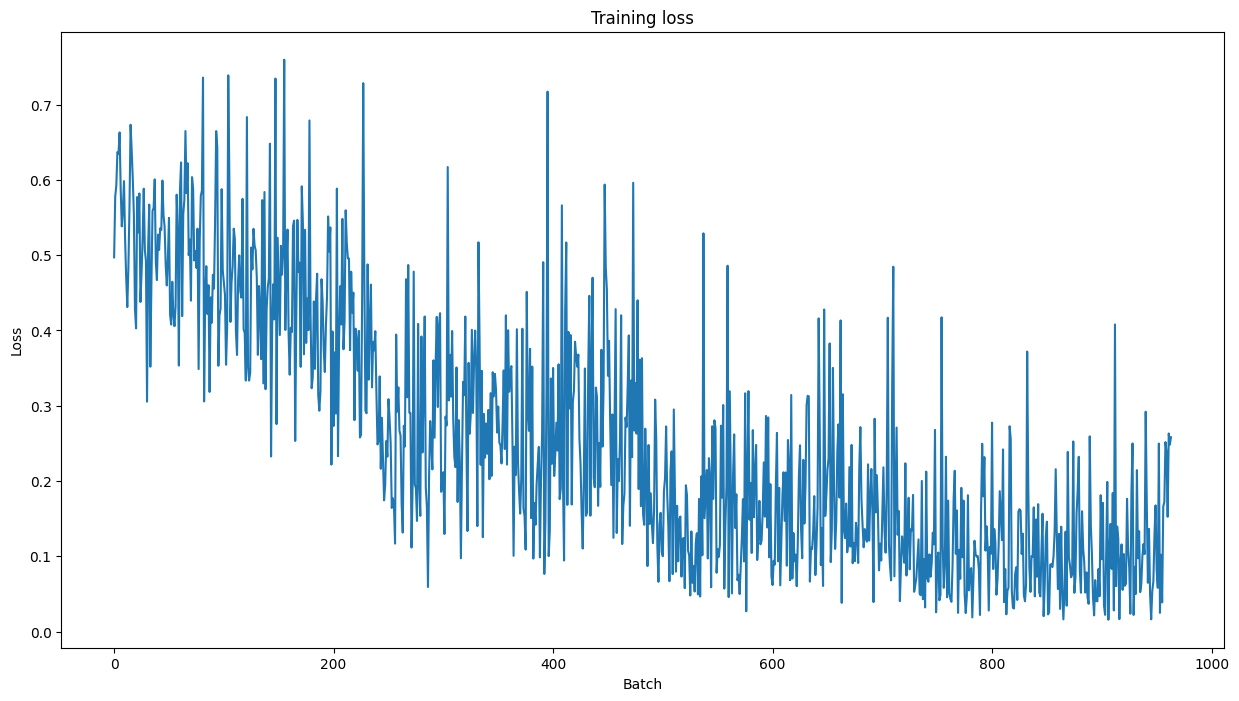

In [42]:
#@title Training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()